In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Concatenate , Add, Dot, Activation, Lambda, BatchNormalization
from tensorflow.keras.models import Model

from tensorflow.image import flip_up_down, flip_left_right, rot90
from tensorflow.linalg import normalize

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import math

import matplotlib.pyplot as plt
import sys 
sys.path.append('..')
from layers.sorted_filters import SortedConv2D

In [2]:
from tensorflow.python.client import device_lib
#tf.disable_v2_behavior()

#print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

print(tf.__version__ )

Num GPUs Available:  1
2.9.1


In [9]:
input_net = Input((32, 32, 3))

y = SortedConv2D(filters=16,activation=tf.nn.relu, padding='VALID')(input_net)
y = BatchNormalization(axis=-1)(y)
y = layers.MaxPooling2D(pool_size=(2, 2))(y) 


y = SortedConv2D(filters=32,activation=tf.nn.relu, padding='SAME')(y)
y = BatchNormalization(axis=-1)(y)
y = SortedConv2D(filters=32,activation=tf.nn.relu, padding='SAME')(y)
y = BatchNormalization(axis=-1)(y)
y = layers.MaxPooling2D(pool_size=(2, 2))(y) 

y = SortedConv2D(filters=64, activation=tf.nn.relu, padding='SAME')(y)
y = BatchNormalization(axis=-1)(y)
y = SortedConv2D(filters=64, activation=tf.nn.relu, padding='SAME')(y)
y = BatchNormalization(axis=-1)(y)
y = SortedConv2D(filters=64, activation=tf.nn.relu, padding='SAME')(y)
y = BatchNormalization(axis=-1)(y)
y = layers.MaxPooling2D(pool_size=(2, 2))(y) 

y = layers.Flatten()(y)
y = layers.Dense(512, activation=tf.nn.relu)(y)
y = layers.Dropout(0.8)(y)
output_net  = layers.Dense(100)(y)

model = Model(inputs = input_net, outputs = output_net)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sorted_conv2d_6 (SortedConv  (None, 30, 30, 16)       160       
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 30, 30, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 16)       0         
 2D)                                                             
                                                                 
 sorted_conv2d_7 (SortedConv  (None, 15, 15, 32)       1568      
 2D)                                                       

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


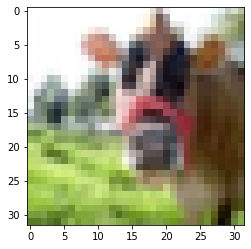

In [4]:
num_classes = 100
input_shape = (32, 32, 3)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()



# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
#x_train = np.expand_dims(x_train, -1)
#x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

plt.imshow(x_train[0,:,:,:])

In [10]:
initial_learning_rate =  0.01
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate,
    first_decay_steps = 100)

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, nesterov=True)



model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
)


checkpoint_filepath = "/tmp/checkpoint"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

batch_size = 100
epochs = 20
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/20
155/500 [========>.....................] - ETA: 4s - loss: 5.0670 - accuracy: 0.0099 - top-5-accuracy: 0.0498

KeyboardInterrupt: 

1/1 [==============================] - 0s 28ms/step
[35] [[ 0.03582753  0.72618073  0.8488876   0.45121306  0.4817271   0.9577669
  -0.531294    0.83325833 -0.7419985   0.25741604 -0.36793384  0.03745469
   1.1549847  -0.34081945 -0.36816293 -0.21825996 -0.56757694  0.6682164
   0.14992408  0.13984829 -0.42981863 -0.9260841  -0.4308847   0.16918433
   0.7044928   0.87067574  0.46853387 -1.0047616   0.6123333   0.27788332
   0.61706275  0.21654405 -0.6213748  -0.73980695  0.09163105  0.88623625
  -0.4622809  -0.32061356 -0.4331843   0.2488109  -0.0879415   0.8974849
   0.2360638   0.5504801   0.13987127  0.64944184 -0.21627733  0.1619634
  -0.61402977 -0.8313057   0.03043384 -0.03756519 -0.39154914  0.10022349
   0.3371423  -0.23220173 -0.22888073 -0.05638329 -0.05573158 -1.2236153
   0.11855534 -0.6778534   0.08149637  0.505174    0.72535884 -2.0284178
   0.8437867   0.9403283  -0.37510434  0.56470877 -0.2632513  -0.61002016
   0.17080142  0.03506331 -0.2765265  -0.3641462   0.3996087 

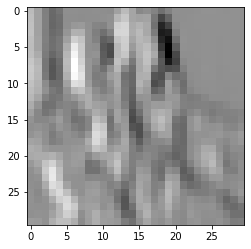

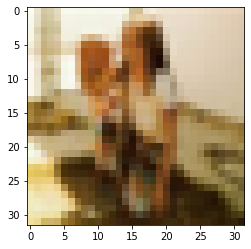

In [15]:
get_layer_output = K.function([model.input], model.layers[1].output)

n = 99

X = np.expand_dims(x_test[n], axis=0)
print(y_test[n], model.predict(X))


layer_out = np.array(get_layer_output([X]))
print(layer_out.shape)
plt.figure(1)  

plt.imshow(layer_out[0, :,:, 0],  cmap='gray_r')   
plt.figure(2)  

plt.imshow(x_test[n],  cmap='gray_r')   

 

In [ ]:
model.layers[4].trainable_variables[3].name

'sorted_conv2d_8/Variable:0'

In [ ]:
model.layers[1].get_scale()

<tf.Variable 'sorted_conv2d_6/Variable:0' shape=() dtype=float32, numpy=nan>

In [ ]:
model.layers[3].get_asym_filter(0,-1)